# Bank Customer Churn Prediction Project

-------------------------------------
## 1. Import Libraries
-------------------------------------

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve

-------------------------------------
## 2. Load and Preprocess Dataset
-------------------------------------

In [6]:
df = pd.read_csv('Churn Modeling.csv')
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df['Exited'] = df['Exited'].astype(int)

X = df.drop('Exited', axis=1)
y = df['Exited']

categorical_cols = ['Geography', 'Gender']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


-------------------------------------
## 3. Build Pipelines
-------------------------------------


In [7]:
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))
])


-------------------------------------
## 4. Evaluation Function
-------------------------------------

In [8]:
def evaluate_model(pipeline, model_name):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]
    
    print(f"----- {model_name} -----")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')



-------------------------------------
## 5. Train & Evaluate All Models
-------------------------------------


----- Logistic Regression -----
Accuracy: 0.813
Precision: 0.631578947368421
Recall: 0.19639934533551553
F1 Score: 0.299625468164794
ROC AUC: 0.7880993012847346

Confusion Matrix:
 [[2319   70]
 [ 491  120]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      2389
           1       0.63      0.20      0.30       611

    accuracy                           0.81      3000
   macro avg       0.73      0.58      0.60      3000
weighted avg       0.79      0.81      0.77      3000

----- Random Forest -----
Accuracy: 0.864
Precision: 0.7622739018087855
Recall: 0.4828150572831424
F1 Score: 0.591182364729459
ROC AUC: 0.8639628986921096

Confusion Matrix:
 [[2297   92]
 [ 316  295]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.76      0.48      0.59       611

    accuracy                           0.86      

/Users/saujanyasriprakash/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [15:52:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


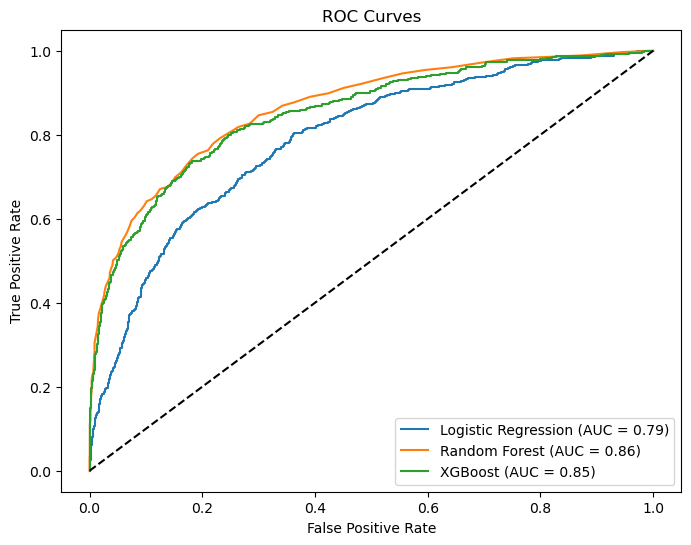

In [9]:
plt.figure(figsize=(8,6))
evaluate_model(logreg_pipeline, "Logistic Regression")
evaluate_model(rf_pipeline, "Random Forest")
evaluate_model(xgb_pipeline, "XGBoost")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()